<a href="https://colab.research.google.com/github/najiba1tagiyeva-ai/najiba1tagiyeva-ai.github.io/blob/main/Machine_Learning_Analysis_Renewable_Energy_in_Azerbaijan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import requests
import pandas as pd
import numpy as np


In [146]:
def fetch_wb(country, indicator, new_name):

    url = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=200"
    r = requests.get(url).json()

    rows = []
    for item in r[1]:
        if item["value"] is not None:
            rows.append({
                "Year": int(item["date"]),
                new_name: float(item["value"])
            })
    return pd.DataFrame(rows)


In [147]:
# GDP per capita (PPP, constant 2017 intl$)
gdp = fetch_wb("AZE", "NY.GDP.PCAP.PP.KD", "GDP_PPP_per_capita")

# Electricity access (% of population)
elec_acc = fetch_wb("AZE", "EG.ELC.ACCS.ZS", "Electricity_Access")

# Population (total)
pop = fetch_wb("AZE", "SP.POP.TOTL", "Population")

# Electric power consumption (kWh per capita)
elec_use = fetch_wb("AZE", "EG.USE.ELEC.KH.PC", "Elec_Use_per_capita")

#
wb = (
    gdp.merge(elec_acc, on="Year", how="inner")
       .merge(pop,      on="Year", how="inner")
       .merge(elec_use, on="Year", how="inner")
       .sort_values("Year")
       .reset_index(drop=True)
)

wb.tail()


,Year,GDP_PPP_per_capita,Electricity_Access,Population,Elec_Use_per_capita
20,2019,20101.491875,100.0,10024283.0,2243.851256
21,2020,19126.096851,100.0,10093121.0,2257.180906
22,2021,20111.375695,100.0,10137750.0,2389.090281
23,2022,21051.244229,100.0,10141756.0,2365.862480
24,2023,21310.738692,100.0,10153958.0,2366.958776


In [148]:
renew = pd.read_csv("Azerbaijan_Renewable_Generation.csv", skiprows=1)

renew = renew.rename(columns={
    "Year": "Year",
    "Electricity statistics": "Renewable_GWh"
})

renew["Year"] = renew["Year"].astype(int)
renew["Renewable_GWh"] = pd.to_numeric(renew["Renewable_GWh"], errors="coerce")
renew = renew[["Year", "Renewable_GWh"]]

renew.tail()


,Year,Renewable_GWh
20,2020,1413.2
21,2021,1617.1
22,2022,1945.2
23,2023,2122.5
24,2024,NaN


In [149]:
df = wb.merge(renew, on="Year", how="inner")
df = df.sort_values("Year").reset_index(drop=True)

df.head(), df.tail()


(   Year  GDP_PPP_per_capita  Electricity_Access  Population  \
 0  2000         5656.929894                98.9   8048600.0   
 1  2001         6168.985121                98.6   8111200.0   
 2  2002         6701.081744               100.0   8171950.0   
 3  2003         7329.406018                98.8   8234100.0   
 4  2004         7937.859479                99.0   8306500.0   
 
    Elec_Use_per_capita  Renewable_GWh  
 0          2040.479090         1534.0  
 1          2106.470066         1301.0  
 2          1996.708252         2020.0  
 3          2235.459856         2469.0  
 4          2281.947872         2755.0  ,
     Year  GDP_PPP_per_capita  Electricity_Access  Population  \
 19  2019        20101.491875               100.0  10024283.0   
 20  2020        19126.096851               100.0  10093121.0   
 21  2021        20111.375695               100.0  10137750.0   
 22  2022        21051.244229               100.0  10141756.0   
 23  2023        21310.738692             

In [150]:
#
df["Total_Elec_kWh"] = df["Elec_Use_per_capita"] * df["Population"]
df["Total_Elec_GWh"] = df["Total_Elec_kWh"] / 1e6

#
df["Renewable_share"] = df["Renewable_GWh"] / df["Total_Elec_GWh"]
df["Renewable_share_pct"] = df["Renewable_share"] * 100

df[["Year", "Renewable_GWh", "Total_Elec_GWh", "Renewable_share_pct"]].tail()


,Year,Renewable_GWh,Total_Elec_GWh,Renewable_share_pct
19,2019,1910.3,22493.0,8.492864
20,2020,1413.2,22782.0,6.203143
21,2021,1617.1,24220.0,6.676713
22,2022,1945.2,23994.0,8.107027
23,2023,2122.5,24034.0,8.831239


In [151]:
corr_df = df[[
    "Elec_Use_per_capita",
    "GDP_PPP_per_capita",
    "Electricity_Access",
    "Population",
    "Renewable_GWh",
    "Renewable_share_pct"
]]

corr = corr_df.corr()
corr


,Elec_Use_per_capita,GDP_PPP_per_capita,Electricity_Access,Population,Renewable_GWh,Renewable_share_pct
Elec_Use_per_capita,1.000000,-0.082664,-0.128771,0.203966,-0.261860,-0.618922
GDP_PPP_per_capita,-0.082664,1.000000,0.855167,0.867859,-0.079546,-0.151427
Electricity_Access,-0.128771,0.855167,1.000000,0.787269,-0.126186,-0.157213
Population,0.203966,0.867859,0.787269,1.000000,-0.300520,-0.444740
Renewable_GWh,-0.261860,-0.079546,-0.126186,-0.300520,1.000000,0.903458
Renewable_share_pct,-0.618922,-0.151427,-0.157213,-0.444740,0.903458,1.000000


In [152]:
import statsmodels.api as sm

X = df[["Elec_Use_per_capita", "GDP_PPP_per_capita", "Population"]]
y = df["Renewable_share"]     # pay (0–1 arasında)

X = sm.add_constant(X)
model_final = sm.OLS(y, X).fit()
print(model_final.summary())


                            OLS Regression Results                            
Dep. Variable:        Renewable_share   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     7.710
Date:                Tue, 20 Jan 2026   Prob (F-statistic):            0.00129
Time:                        20:20:06   Log-Likelihood:                 52.567
No. Observations:                  24   AIC:                            -97.13
Df Residuals:                      20   BIC:                            -92.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6051    

In [153]:
df["Renewable_share_pct"] = df["Renewable_share"] * 100
df["Predicted_share_pct"] = model_final.fittedvalues * 100

regviz = df[["Year", "Renewable_share_pct", "Predicted_share_pct"]]
regviz.to_csv("AZ_Renewable_Regression.csv", index=False)

regviz.tail()


,Year,Renewable_share_pct,Predicted_share_pct
19,2019,8.492864,8.085124
20,2020,6.203143,7.322974
21,2021,6.676713,6.559935
22,2022,8.107027,7.059088
23,2023,8.831239,7.094886


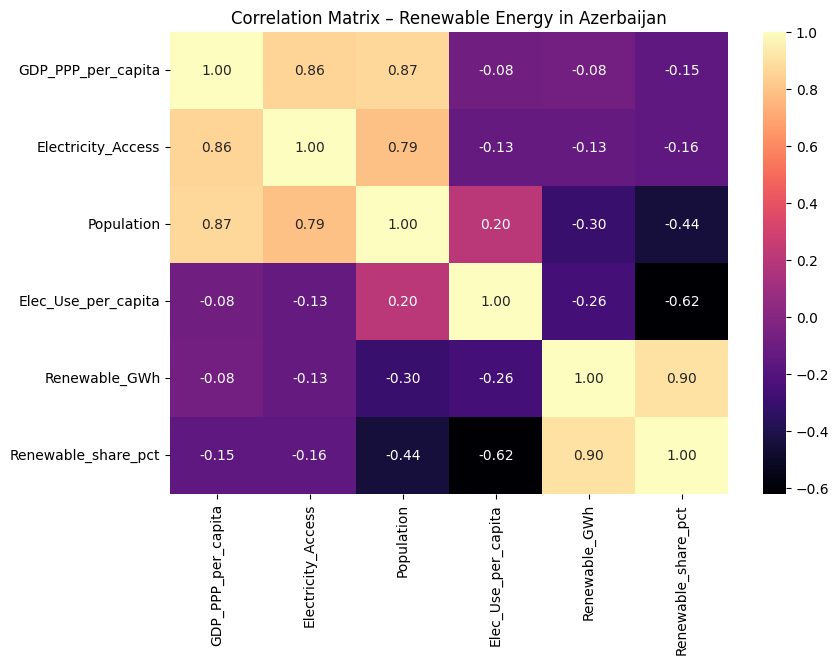

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[[
    "GDP_PPP_per_capita",
    "Electricity_Access",
    "Population",
    "Elec_Use_per_capita",
    "Renewable_GWh",
    "Renewable_share_pct"
]].corr()

plt.figure(figsize=(9,6))
sns.heatmap(corr, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Matrix – Renewable Energy in Azerbaijan")
plt.show()


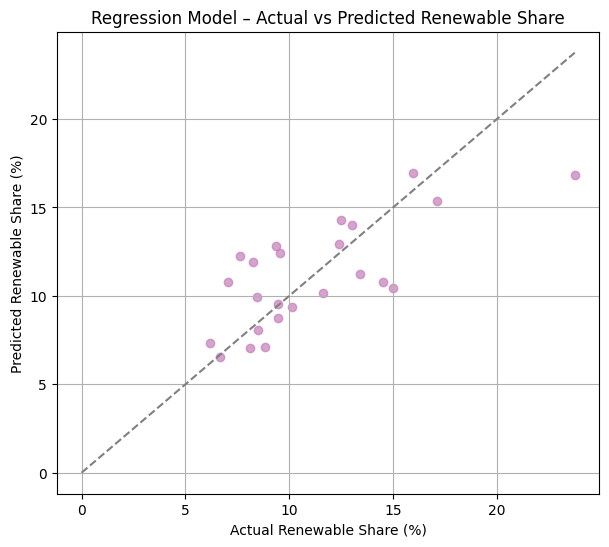

In [155]:
plt.figure(figsize=(7,6))
plt.scatter(df["Renewable_share_pct"], df["Predicted_share_pct"], color="#C57DBA", alpha=0.7)
plt.plot([0,max(df["Renewable_share_pct"])], [0,max(df["Renewable_share_pct"])],
         linestyle='--', color='gray')

plt.xlabel("Actual Renewable Share (%)")
plt.ylabel("Predicted Renewable Share (%)")
plt.title("Regression Model – Actual vs Predicted Renewable Share")
plt.grid(True)
plt.show()


In [156]:
#
corr_vars = [
    "Renewable_share",      #
    "Elec_Use_per_capita",
    "GDP_PPP_per_capita",
    "Population"
]

corr_df = df[corr_vars].corr().round(2)

#
corr_long = (
    corr_df.stack()
           .reset_index()
           .rename(columns={
               "level_0": "Var1",
               "level_1": "Var2",
               0: "Correlation"
           })
)

corr_long.to_csv("Correlation_Data_Azerbaijan.csv", index=False)


In [157]:
import statsmodels.api as sm

#
X = df[["Elec_Use_per_capita", "GDP_PPP_per_capita", "Population"]]
y = df["Renewable_share"]

X_const = sm.add_constant(X)
model_final = sm.OLS(y, X_const).fit()

#
df["Predicted_share"] = model_final.fittedvalues

reg_data = df[["Year", "Renewable_share", "Predicted_share"]]
reg_data.to_csv("Regression_Actual_vs_Predicted_Azerbaijan.csv", index=False)
